In [321]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

from collections import Counter, defaultdict

import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
# sns.set()
sns.set_style("whitegrid")

In [293]:
def load_data(path, size, ratio=0.5):
    fnames = ["neg_neg.npy", "neg_pos.npy", "pos_neg.npy", "pos_pos.npy"]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []
    n1 = int(size * ratio / 2)
    n2 = int(size * (1 - ratio) / 2)
    print(n1, n2)

    for fname, p_label, m_label, n in zip(fnames, protected_labels, main_labels, [n1, n2, n2, n1]):
        print(path + '/' + fname)
#         print(np.load(path + '/' + fname).shape)
        data = np.load(path + '/' + fname)[:n]
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=0)
    return X, Y_p, Y_m

In [306]:
ratio=0.9
x_train, y_p_train, y_m_train = load_data('/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/train/'.format(ratio), size=40000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data('/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/dev/'.format(ratio), size=2000, ratio=ratio)

18000 1999
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//pos_pos.npy
900 99
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//pos_pos.npy


In [311]:
# P = np.load('/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/P.num-clfs=80_max_iter:1200.npy')
P = np.load('/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/P.num-clfs=50.npy'.format(ratio))

In [314]:
P

array([[ 0.86282387,  0.0144113 , -0.0009032 , ...,  0.0029939 ,
        -0.00156565, -0.00573828],
       [ 0.0144113 ,  0.79468199, -0.03747557, ..., -0.02430522,
        -0.01156241,  0.03200774],
       [-0.0009032 , -0.03747557,  0.83954128, ..., -0.00851192,
        -0.01221959,  0.00907987],
       ...,
       [ 0.0029939 , -0.02430522, -0.00851192, ...,  0.87498129,
        -0.03662106, -0.02067439],
       [-0.00156565, -0.01156241, -0.01221959, ..., -0.03662106,
         0.86551077, -0.01418183],
       [-0.00573828,  0.03200774,  0.00907987, ..., -0.02067439,
        -0.01418183,  0.86690174]])

In [312]:
debiased_x_train = x_train.dot(P)
debiased_x_dev = x_dev.dot(P)

In [309]:
%%time

biased_classifier = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)

biased_classifier.fit(x_train, y_m_train)
biased_classifier.score(x_dev, y_m_dev)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
CPU times: user 922 ms, sys: 369 ms, total: 1.29 s
Wall time: 902 ms


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.8s finished


0.8788788788788788

In [313]:
%%time

# classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False)
# classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=1000, random_state=0, tol=1e-3)
classifier = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)
# classifier = MLPClassifier(activation = "identity", hidden_layer_sizes = (100,), max_iter = 15)

classifier.fit(debiased_x_train, y_m_train)
classifier.score(debiased_x_dev, y_m_dev)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
CPU times: user 1.07 s, sys: 330 ms, total: 1.4 s
Wall time: 1.05 s


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    1.0s finished


0.5045045045045045

In [146]:
def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [299]:
# before debiasing
get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)

(defaultdict(dict,
             {'y:0': {'p:0': 0.90875, 'p:1': 0.48743718592964824},
              'y:1': {'p:0': 0.5477386934673367, 'p:1': 0.92}}),
 {'y:0': 0.4213128140703517, 'y:1': -0.3722613065326633})

In [300]:
# after debiasing
get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)

(defaultdict(dict,
             {'y:0': {'p:0': 0.8175, 'p:1': 0.6030150753768844},
              'y:1': {'p:0': 0.678391959798995, 'p:1': 0.78125}}),
 {'y:0': 0.21448492462311564, 'y:1': -0.10285804020100497})

In [301]:
classifier.score(debiased_x_dev, y_m_dev)

0.7677677677677678

In [350]:
results = defaultdict(dict)

for ratio in [0.5, 0.6, 0.7, 0.8, 0.9]:
# for ratio in [0.5, 0.6]:
# for ratio in [0.5]:
    x_train, y_p_train, y_m_train = load_data(
        '/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/train/'.format(ratio),
        size=40000, ratio=ratio)
    x_dev, y_p_dev, y_m_dev = load_data(
        '/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/dev/'.format(ratio),
        size=2000, ratio=ratio)
    

    biased_classifier = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    
    P = np.load('/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_{}/P.num-clfs=120.npy'.format(ratio))
    debiased_x_train = x_train.dot(P)
    debiased_x_dev = x_dev.dot(P)
    
    classifier = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    
    
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    
    results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
    results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
    
    results[ratio]['biased_acc'] = biased_score
    results[ratio]['debiased_acc'] = debiased_score

10000 10000
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/train//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/train//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/train//pos_pos.npy
500 500
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.5/dev//pos_pos.npy


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
12000 8000
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/train//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/train//neg_pos.npy


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished


/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/train//pos_pos.npy
600 400
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.6/dev//pos_pos.npy


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
14000 6000
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/train//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/train//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/train//pos_pos.npy


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.8s finished


700 300
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.7/dev//pos_pos.npy


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
16000 3999
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/train//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/train//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/train//pos_pos.npy


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished


800 199
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.8/dev//pos_pos.npy


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
18000 1999
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//neg_neg.npy


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished


/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/train//pos_pos.npy
900 99
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//neg_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//neg_pos.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//pos_neg.npy
/home/nlp/lazary/workspace/thesis/nullspace_projection/data/emoji_sent_race_0.9/dev//pos_pos.npy


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


/home/nlp/lazary/anaconda3/envs/nullspace/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    1.0s finished


In [316]:
results

defaultdict(dict,
            {0.5: {'biased_diff_tpr': 0.18799999999999994,
              'debiased_diff_tpr': 0.16600000000000004,
              'biased_acc': 0.753,
              'debiased_acc': 0.6165},
             0.6: {'biased_diff_tpr': 0.2833333333333333,
              'debiased_diff_tpr': 0.16000000000000003,
              'biased_acc': 0.779,
              'debiased_acc': 0.713},
             0.7: {'biased_diff_tpr': 0.33238095238095233,
              'debiased_diff_tpr': 0.2585714285714286,
              'biased_acc': 0.7985,
              'debiased_acc': 0.673},
             0.8: {'biased_diff_tpr': 0.4213128140703517,
              'debiased_diff_tpr': 0.21448492462311564,
              'biased_acc': 0.8353353353353353,
              'debiased_acc': 0.7677677677677678},
             0.9: {'biased_diff_tpr': 0.5249494949494949,
              'debiased_diff_tpr': -0.013232323232323151,
              'biased_acc': 0.8788788788788788,
              'debiased_acc': 0.523023023

In [347]:
results

defaultdict(dict,
            {0.5: {'biased_diff_tpr': 0.04400000000000004,
              'debiased_diff_tpr': 0.07200000000000006,
              'biased_acc': 0.753,
              'debiased_acc': 0.6165},
             0.6: {'biased_diff_tpr': -0.09666666666666668,
              'debiased_diff_tpr': -0.004166666666666652,
              'biased_acc': 0.779,
              'debiased_acc': 0.713},
             0.7: {'biased_diff_tpr': -0.23476190476190484,
              'debiased_diff_tpr': -0.04047619047619044,
              'biased_acc': 0.7985,
              'debiased_acc': 0.673},
             0.8: {'biased_diff_tpr': -0.3722613065326633,
              'debiased_diff_tpr': -0.10285804020100497,
              'biased_acc': 0.8353353353353353,
              'debiased_acc': 0.7677677677677678},
             0.9: {'biased_diff_tpr': -0.4507070707070707,
              'debiased_diff_tpr': 0.02535353535353535,
              'biased_acc': 0.8788788788788788,
              'debiased_acc': 0.5

In [351]:
plot_results = defaultdict(list)
for r in [0.5, 0.6, 0.7, 0.8]:
    plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
    plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
    plot_results['biased_acc'].append(results[r]['biased_acc'])
    plot_results['debiased_acc'].append(results[r]['debiased_acc'])
    

In [318]:
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.18799999999999994,
              0.2833333333333333,
              0.33238095238095233,
              0.4213128140703517],
             'debiased_diff_tpr': [0.16600000000000004,
              0.16000000000000003,
              0.2585714285714286,
              0.21448492462311564],
             'biased_acc': [0.753, 0.779, 0.7985, 0.8353353353353353],
             'debiased_acc': [0.6165, 0.713, 0.673, 0.7677677677677678]})

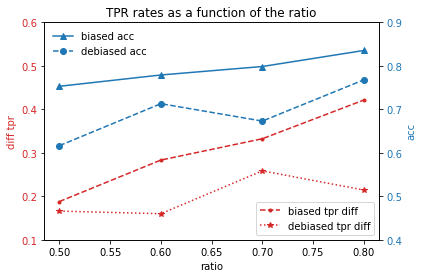

In [398]:
def data2plot(results):
    x = [0.5, 0.6, 0.7, 0.8]

#     ax = plt.plot(x, results['biased_diff_tpr'], '.--', label='biased tpr diff')
#     ax = plt.plot(x, results['debiased_diff_tpr'], '*:', label='debiased tpr diff')
#     ax = plt.plot(x, results['biased_acc'], '^-', label='biased acc')
#     ax = plt.plot(x, results['debiased_acc'], 'o--', label='debiased acc')

#     plt.annotate(#'48.1%', size=8,
#     ha = 'center', va = 'bottom',
#     xytext = (65, 0.455),
#     xy = (75.2, 0.479),
#     arrowprops = { 'facecolor' : 'black', 'shrink' : 0.001, 'width': 0.5, 'headwidth': 6, 'headlength': 8 })

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('ratio')
    ax1.set_ylabel('diff tpr', color=color)
    ax1.plot(x, results['biased_diff_tpr'], '.--', label='biased tpr diff', color=color)
    ax1.plot(x, results['debiased_diff_tpr'], '*:', label='debiased tpr diff', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ylim(0.1,0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, results['biased_acc'], '^-', label='biased acc', color=color)
    ax2.plot(x, results['debiased_acc'], 'o--', label='debiased acc', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    ax2.legend(lines, labels, loc='lower right')
    
    from matplotlib.legend import Legend
    leg = Legend(ax2, lines2, labels2,
             loc='upper left', frameon=False)
    ax2.add_artist(leg);

#     plt.ylabel('val')
#     plt.xlabel('Ratio')
    plt.title('TPR rates as a function of the ratio')
#     plt.tight_layout()
    plt.ylim(0.4,.9)
#     plt.legend()
    plt.savefig('tpr_rates_ratio.png', dpi=1000)
    plt.show()
    
data2plot(plot_results)

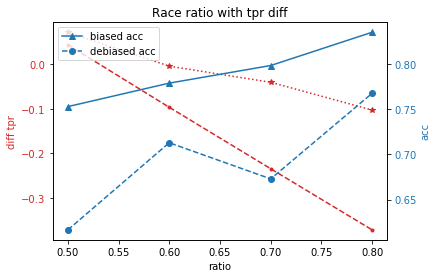

In [349]:
data2plot(plot_results)